The goal of this notebook is to enable fixation extraction and annotate the fixations with corresponding scene information. For now we will use the I-DT dispersion-based fixation detection algorithm used by Sitzmann et al., applied in the 2D geographic coordinate space.

I-DT requires two parameters: 
* Maximum dispersion  
    - We set this to 1 degree, in keeping with Sitzmann et al. 
* Fixation duration
    - Sitzmann et al. set this to 150ms, which seems restrictive
    - We set this to the mean fixation duration for visual search minus one standard deviation, as reported in Van der Lans et al. 
    - Ideally, we would conduct a meta-analysis of this quantity that is agnostic to the detection algorithm

References:
* Salvucci, D. D., & Goldberg, J. H. (2000). Identifying fixations and saccades in eye-tracking protocols. In Proceedings of the 2000 symposium on Eye tracking research & applications (pp. 71-78). ACM.
* Sitzmann, V., Serrano, A., Pavel, A., Agrawala, M., Gutierrez, D., Masia, B., & Wetzstein, G. (2018). Saliency in VR: How do people explore virtual environments?. IEEE transactions on visualization and computer graphics, 24(4), 1633-1642.
* Van der Lans, R., Wedel, M., & Pieters, R. (2011). Defining eye-fixation sequences across individuals and tasks: the Binocular-Individual Threshold (BIT) algorithm. Behavior Research Methods, 43(1), 239-257.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import pickle
import imageio
import random 
from scipy.spatial import distance
from time import perf_counter
import visual_search_load
from statistics import mode
from statsmodels.stats.anova import AnovaRM
from scipy import stats

pd.options.mode.chained_assignment = None

In [2]:
## Set directories. 
data_direc = '/Users/angelaradulescu/Dropbox (Facebook)/Cognitive-Science-Consortium/VisualSearch/Gaze/data/'
equirect_direc = '/Users/angelaradulescu/Dropbox (Facebook)/VisualSearch/VisualSearchSpheres/'

## Load data (~1min). 
gaze = pd.read_csv(data_direc + 'gaze_objects_with_features.csv', index_col=False)

In [3]:
## Get some metadata.
all_participants = np.unique(gaze['participant'].values)
all_scenes = np.unique(gaze['scene'].values)

In [4]:
## Save lean dataframe for importing into R to do fixation extraction. 
gaze_fix_ready = gaze[['trial','timepoint','gaze_pos_geo_lat','gaze_pos_geo_long']]
gaze_fix_ready['timepoint'] = np.arange(len(gaze_fix_ready))
gaze_fix_ready.to_csv(data_direc + '/fixation_extraction/gaze_fix_ready.csv')

In [5]:
gaze_fix_ready.head(15)

,trial,timepoint,gaze_pos_geo_lat,gaze_pos_geo_long
0,1,0,NaN,NaN
1,1,1,NaN,NaN
2,1,2,NaN,NaN
3,1,3,NaN,NaN
4,1,4,NaN,NaN
5,1,5,NaN,NaN
6,1,6,NaN,NaN
7,1,7,NaN,NaN
8,1,8,NaN,NaN
9,1,9,74.6523,173.4625


In [6]:
## Load fixations (assuming R script has been run).
extracted_fixations = pd.read_csv(data_direc + '/fixation_extraction/extracted_fixations.csv', index_col=False)

### Check first trial.

In [7]:
## Get first trial fixations. 
gaze_first_trial = gaze[gaze['trial'] == 1]
last_tp = gaze_first_trial['timepoint'].values[-1]
fixations_first_trial = extracted_fixations[extracted_fixations['end'] < last_tp]
fixations_first_trial.head(5)

,Unnamed: 0,start,end,dur,x,y
0,1,0,10,10,173.462500,74.652300
1,2,27,42,15,180.035638,91.319244
2,3,53,69,16,181.250847,88.764718
3,4,76,96,20,178.726267,74.768967
4,5,137,148,11,174.885475,69.875975


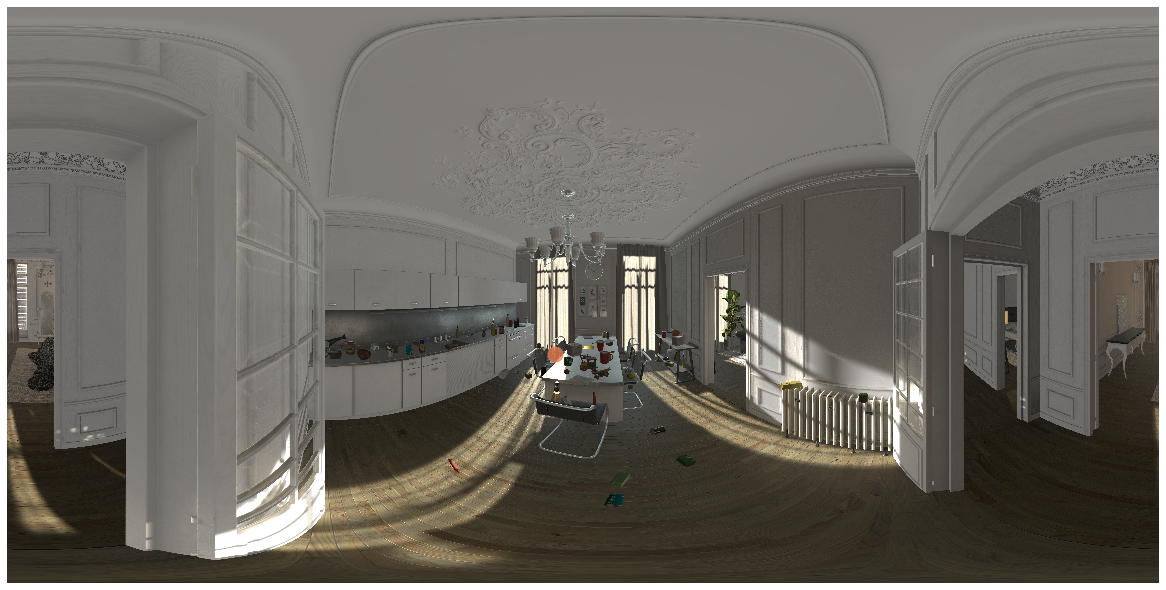

In [13]:
## Get scene.
scene = gaze_first_trial['scene'].values[0]

## Load equirect for this scene.
im = imageio.imread(equirect_direc + scene + '.png')

## Grab enough colors to plot this trial's gaze. 
n_samples, dummy = fixations_first_trial.shape
cm_subsection = np.linspace(0.0, 1.0, n_samples)
colors = [cm.plasma(x) for x in cm_subsection]

## Make plot.
fig = plt.figure()
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(im, extent=[0, 360, 0, 180])

## Plot single fixation. Compare 9 and 17 to see effects of occlusion.
f_idx = 17

for i, color in enumerate(colors):
    if i == f_idx:
        # Plot point. 
        ax.plot(fixations_first_trial['x'].values[i],fixations_first_trial['y'].values[i],
                'o',markersize=15,color=color, alpha=0.75);
this_fix = gaze_fix_ready.index[(gaze_fix_ready['timepoint'] >= fixations_first_trial['start'].values[f_idx]) & (gaze_fix_ready['timepoint'] <= fixations_first_trial['end'].values[f_idx])]
occluded_pos = gaze.iloc[this_fix][['nearest_obj_x_loc_pixel_360', 'nearest_obj_y_loc_pixel_360']].values[0]
ax.set_axis_off()

### Tag samples with corresponding fixations.

In [11]:
## Make fixation indicator vector.
fixations_indexed_into_timepoints = np.ones(len(gaze_fix_ready))*(-999)

## Interlace indices.
a = extracted_fixations['start'].values
b = extracted_fixations['end'].values+1
c = np.empty((a.size + b.size,), dtype=a.dtype)
c[0::2] = a
c[1::2] = b

## Bin the timepoints based on interval indices, removing samples between fixations. 
indices = np.digitize(gaze_fix_ready['timepoint'].values, c)
# Get indices for when we were in a fixation.
fix_indices = np.where(np.mod(indices,2) != 0)
# Get fixation labels. 
fix_labels = (indices[np.mod(indices,2) != 0]-1)/2+1
# Index into fixation indicator vector.
fixations_indexed_into_timepoints[fix_indices] = fix_labels

## Insert into gaze dataframe. 
gaze.insert(3, 'fixation', fixations_indexed_into_timepoints.astype(int))
gaze = gaze.replace(-999, np.nan)

In [14]:
## Re-index fixations within scene. ~17 min 
# Is there nicer syntax to do this? Possibly apply/lambda functions, or some clever list comprehension? 
# See below. 
t_start = perf_counter()

## Preload columns to save subsetting time.
participant_col = gaze['participant'].values
scene_col = gaze['scene'].values
fixation_col = gaze['fixation'].values

## Initialize index array.
fixation_reindexed = np.ones(len(gaze_fix_ready))*(-999)

## Participant loop. 
for p in all_participants:
    
    ## Scene loop. 
    for s in all_scenes: 
             
        ## Reindex fixations for this episode. 
        fix_this_episode = fixation_col[(participant_col == p) & (scene_col == s)]
        
        ## Deal with episodes in which we don't have any fixations. 
        if fix_this_episode[~np.isnan(fix_this_episode)].shape[0] != 0:
            first_fix = fix_this_episode[~np.isnan(fix_this_episode)][0]     
            fix_this_episode_reindexed = (fix_this_episode - first_fix)+1
        else:
            fix_this_episode_reindexed = fix_this_episode
        
        ## Plug into index array. 
        fixation_reindexed[(participant_col == p) & (scene_col == s)] = fix_this_episode_reindexed    
                
t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds')  

Elapsed time:  968.6541715620001 seconds


In [18]:
## Insert into gaze dataframe. 
gaze_copy = gaze.copy()
gaze_copy['fixation'] = fixation_reindexed
gaze_copy = gaze_copy.replace(-999, np.nan)

In [19]:
## Save.
gaze_copy.to_csv(data_direc + '/fixation_extraction/gaze_fix_tagged.csv', index=False)

In [8]:
## Load fixation-tagged dataframe.
gaze_fix_tagged = pd.read_csv(data_direc + '/fixation_extraction/gaze_fix_tagged.csv')

In [9]:
gaze_fix_tagged.head(10)

,participant,timepoint,timestamp,fixation,frame,trial,condition,scene,object,valid,...,target_loc_r_polar,target_loc_theta_polar,target_x_loc_pixel_360,target_y_loc_pixel_360,target_shape_1,target_shape_2,target_shape_3,target_color_1,target_color_2,target_color_3
0,P2_09262018,0,29.9210,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
1,P2_09262018,1,29.9309,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
2,P2_09262018,2,29.9312,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
3,P2_09262018,3,29.9315,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
4,P2_09262018,4,29.9507,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
5,P2_09262018,5,29.9619,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
6,P2_09262018,6,29.9621,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
7,P2_09262018,7,29.9729,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
8,P2_09262018,8,29.9837,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
9,P2_09262018,9,29.9841,1.0,261,1,Static,Kitchen Location 1 Trial 9,MrChair,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756


### Extract fixations without annotations.

In [32]:
## Grab participants.
indexes = np.unique(gaze_fix_tagged['participant'].values, return_index=True)[1]
participants = [gaze_fix_tagged['participant'].values[index] for index in sorted(indexes)]

## Until we get occlusion tagging, we'll only consider samples for which we had an object label. 
gaze_valid = gaze_fix_tagged

## Drop samples between fixations.
gaze_valid = gaze_valid.dropna(subset=['fixation']).reset_index(drop=True)   

### Re-annotate fixations.

This annotation assumes that within a fixation, the labels of objects are non-ambiguous. That is, even though there could be multiple rubber ducks in a scene, each fixation would only ever contain one of them. 

In [16]:
## Grab participants.
indexes = np.unique(gaze_fix_tagged['participant'].values, return_index=True)[1]
participants = [gaze_fix_tagged['participant'].values[index] for index in sorted(indexes)]

## Until we get occlusion tagging, we'll only consider samples for which we had an object label. 

## Drop samples between fixations.
gaze_valid = gaze_valid.dropna(subset=['fixation']).reset_index(drop=True)   

In [17]:
gaze_valid

,participant,timepoint,timestamp,fixation,frame,trial,condition,scene,object,valid,...,target_loc_r_polar,target_loc_theta_polar,target_x_loc_pixel_360,target_y_loc_pixel_360,target_shape_1,target_shape_2,target_shape_3,target_color_1,target_color_2,target_color_3
0,P2_09262018,0,29.9210,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
1,P2_09262018,1,29.9309,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
2,P2_09262018,2,29.9312,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
3,P2_09262018,3,29.9315,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
4,P2_09262018,4,29.9507,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378312,P26_10112018,122,2883.6987,3.0,86131,300,Dynamic,Studio Location 5 Trial 9,Cup,1,...,0.5935,-0.3066,4870.0,2448.0,44.8949,-1.3452,-0.7614,-90007.5613,99071.0635,7935.9880
1378313,P26_10112018,123,2883.7095,3.0,86131,300,Dynamic,Studio Location 5 Trial 9,Cup,1,...,0.5935,-0.3066,4870.0,2448.0,44.8949,-1.3452,-0.7614,-90007.5613,99071.0635,7935.9880
1378314,P26_10112018,124,2883.7208,3.0,86131,300,Dynamic,Studio Location 5 Trial 9,Cup,1,...,0.5935,-0.3066,4870.0,2448.0,44.8949,-1.3452,-0.7614,-90007.5613,99071.0635,7935.9880
1378315,P26_10112018,125,2883.7317,3.0,86132,300,Dynamic,Studio Location 5 Trial 9,Cup,1,...,0.5935,-0.3066,4870.0,2448.0,44.8949,-1.3452,-0.7614,-90007.5613,99071.0635,7935.9880


In [27]:
t_start = perf_counter()

def most_frequent(test_list):
    return max(set(test_list), key=test_list.count)

def most_frequent_idx(test_list):
    return np.where(np.array(test_list) == most_frequent(test_list))[0]

## Initialize list for all fixations. 
fixation_data = []

for p in participants: 
    
    print(p)

    ## Subselect data for one participant. 
    fixations_single_participant = gaze_valid[gaze_valid['participant'] == p]

    ## Grab scenes in the order that the participant has experienced them.
    indexes = np.unique(fixations_single_participant['scene'].values, return_index=True)[1]
    scenes = [fixations_single_participant['scene'].values[index] for index in sorted(indexes)]

    ## Initialize lists. 
    all_fixations = []
    all_fixation_props = []
    all_fixation_durations = []
    all_fixation_cum_durations = []
    all_last_fixation = []

    ## Scene loop.
    for s in scenes: 

        ## Subset this episode's fixations.
        this_episode = fixations_single_participant[fixations_single_participant['scene'] == s].reset_index(drop=True)
        fixations_this_episode = np.unique(this_episode['fixation'].values)
        n_fixations = fixations_this_episode.shape[0]

        ## Re-index fixations (we lost some fixations when restricting ourselves to valid objects).
        all_fixations.append(np.arange(fixations_this_episode.shape[0]) + 1)

        ## Label fixation with most frequently tagged object. 
        fixated_objects = [most_frequent(list(this_episode[this_episode['fixation'] == f]['object'].values)) for f in fixations_this_episode]

        ## Grab scene properties corresponding to each fixated object. 
        fixated_objects_props = [this_episode[this_episode['fixation'] == f].iloc[most_frequent_idx(list(this_episode[this_episode['fixation'] == f]['object'].values))[0]].values for f in fixations_this_episode]
        all_fixation_props.append(fixated_objects_props)

        ## Record fixation duration (in samples).
        fixation_durations = [len(this_episode[this_episode['fixation'] == f]) for f in fixations_this_episode]
        all_fixation_durations.append(fixation_durations)
        all_fixation_cum_durations.append(np.cumsum(fixation_durations))
        
        ## Record last fixation.
        all_last_fixation.append(np.ones(len(fixations_this_episode)) * len(fixations_this_episode))
        
    ## Stack lists.
    all_fixations = pd.DataFrame(np.hstack(all_fixations))
    all_fixation_props = pd.DataFrame(np.vstack(all_fixation_props), columns = fixations_single_participant.columns)
    all_fixation_durations = np.hstack(all_fixation_durations)
    all_fixation_cum_durations = np.hstack(all_fixation_cum_durations)
    all_last_fixation = np.hstack(all_last_fixation)
    fixations = all_fixation_props.copy()
    fixations = all_fixations.copy()

    ## Clean up unnescessary columns and naming conventions.
    fixations = fixations.drop(['timepoint', 'timestamp', 'fixation', 'valid', 'nearest_obj'], axis=1)
    fixations = fixations.rename(columns={"nearest_obj_idx_within_scene": "obj_idx_within_scene",
                                  "nearest_obj_loc_r_polar": "obj_loc_r_polar", 
                                  "nearest_obj_loc_theta_polar": "obj_loc_theta_polar", 
                                  "nearest_obj_x_loc_pixel_360": "obj_x_loc_pixel_360", 
                                  "nearest_obj_y_loc_pixel_360": "obj_y_loc_pixel_360"})

    ## Add duration and re-indexed fixation.
    fixations.insert(loc=3, column='fixation', value=all_fixations)
    fixations.insert(loc=4, column='duration', value=all_fixation_durations)
    fixations.insert(loc=5, column='cumulative_duration', value=all_fixation_cum_durations)
    fixations.insert(loc=5, column='last_fixation', value=all_last_fixation)
    
    ## Append to master list. 
    fixation_data.append(fixations)

fixation_data = pd.concat(fixation_data)
t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds')  

P2_09262018


/Users/angelaradulescu/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
## Save.
fixation_data.to_csv(data_direc + '/fixation_extraction/fixations.csv', index=False)

In [24]:
all_fixations.shape

(3150,)

In [29]:
this_episode[this_episode['fixation'] == 1]

,participant,timepoint,timestamp,fixation,frame,trial,condition,scene,object,valid,...,target_loc_r_polar,target_loc_theta_polar,target_x_loc_pixel_360,target_y_loc_pixel_360,target_shape_1,target_shape_2,target_shape_3,target_color_1,target_color_2,target_color_3
0,P2_09262018,0,29.9210,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
1,P2_09262018,1,29.9309,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
2,P2_09262018,2,29.9312,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
3,P2_09262018,3,29.9315,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
4,P2_09262018,4,29.9507,1.0,260,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
5,P2_09262018,5,29.9619,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
6,P2_09262018,6,29.9621,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
7,P2_09262018,7,29.9729,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
8,P2_09262018,8,29.9837,1.0,261,1,Static,Kitchen Location 1 Trial 9,NaN,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756
9,P2_09262018,9,29.9841,1.0,261,1,Static,Kitchen Location 1 Trial 9,MrChair,0,...,-0.3653,-0.1774,3620.0,2279.0,47.9704,-1.4286,-0.8345,-13206.1187,-20800.6251,2591.4756


In [30]:
fixations_this_episode

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27.])

In [31]:
[this_episode[this_episode['fixation'] == f].iloc[most_frequent_idx(list(this_episode[this_episode['fixation'] == f]['object'].values))[0]].values for f in fixations_this_episode]

/Users/angelaradulescu/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


IndexError: index 0 is out of bounds for axis 0 with size 0